In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import cv2

In [2]:
def minmod(x, y):
    return np.sign(x) * np.maximum(np.minimum(np.abs(x), np.sign(x) * y), 1e-10)


def get_L_component(rho, u, v, w, By, Bz, p, axis):
    rho_L = rho + 1/2 * minmod(rho - np.roll(rho, 1, axis=axis), np.roll(rho, -1, axis=axis) - rho)
    u_L = u + 1/2 * minmod(u - np.roll(u, 1, axis=axis), np.roll(u, -1, axis=axis) - u)
    v_L = v + 1/2 * minmod(v - np.roll(v, 1, axis=axis), np.roll(v, -1, axis=axis) - v)
    w_L = w + 1/2 * minmod(w - np.roll(w, 1, axis=axis), np.roll(w, -1, axis=axis) - w)
    By_L = By + 1/2 * minmod(By - np.roll(By, 1, axis=axis), np.roll(By, -1, axis=axis) - By)
    Bz_L = Bz + 1/2 * minmod(Bz - np.roll(Bz, 1, axis=axis), np.roll(Bz, -1, axis=axis) - Bz)
    p_L = p + 1/2 * minmod(p - np.roll(p, 1, axis=axis), np.roll(p, -1, axis=axis) - p)

    return rho_L, u_L, v_L, w_L, By_L, Bz_L, p_L


def get_R_component(rho, u, v, w, By, Bz, p, axis):
    rho_R = np.roll(rho, -1, axis=axis) - 1/2 * minmod(np.roll(rho, -1, axis=axis) - rho, np.roll(rho, -2, axis=axis) - np.roll(rho, -1, axis=axis))
    u_R = np.roll(u, -1, axis=axis) - 1/2 * minmod(np.roll(u, -1, axis=axis) - u, np.roll(u, -2, axis=axis) - np.roll(u, -1, axis=axis))
    v_R = np.roll(v, -1, axis=axis) - 1/2 * minmod(np.roll(v, -1, axis=axis) - v, np.roll(v, -2, axis=axis) - np.roll(v, -1, axis=axis))
    w_R = np.roll(w, -1, axis=axis) - 1/2 * minmod(np.roll(w, -1, axis=axis) - w, np.roll(w, -2, axis=axis) - np.roll(w, -1, axis=axis))
    By_R = np.roll(By, -1, axis=axis) - 1/2 * minmod(np.roll(By, -1, axis=axis) - By, np.roll(By, -2, axis=axis) - np.roll(By, -1, axis=axis))
    Bz_R = np.roll(Bz, -1, axis=axis) - 1/2 * minmod(np.roll(Bz, -1, axis=axis) - Bz, np.roll(Bz, -2, axis=axis) - np.roll(Bz, -1, axis=axis))
    p_R = np.roll(p, -1, axis=axis) - 1/2 * minmod(np.roll(p, -1, axis=axis) - p, np.roll(p, -2, axis=axis) - np.roll(p, -1, axis=axis))
    
    return rho_R, u_R, v_R, w_R, By_R, Bz_R, p_R


def get_U_parameters_1(rho, u, v, w, Bx, By, Bz, e, pT, pT1, S, SM):
    rho1 = rho * (S - u) / (S - SM)
    u1 = SM
    v1 = v - Bx * By * (SM - u) / (rho * (S - u) * (S - SM) - Bx**2)
    w1 = w - Bx * Bz * (SM - u) / (rho * (S - u) * (S - SM) - Bx**2)
    By1 = By * (rho * (S - u)**2 - Bx**2) / (rho * (S - u) * (S - SM) - Bx**2)
    Bz1 = Bz * (rho * (S - u)**2 - Bx**2) / (rho * (S - u) * (S - SM) - Bx**2)
    e1 = ((S - u) * e - pT * u + pT1 * SM + Bx * ((u*Bx + v*By + w*Bz) - (u1*Bx + v1*By1 + w1*Bz1))) / (S - SM)
    
    return rho1, u1, v1, w1, By1, Bz1, e1


def get_U_parameters_2(rho1_L, rho1_R, u1_L, u1_R, v1_L, v1_R, w1_L, w1_R, Bx, By1_L, By1_R, Bz1_L, Bz1_R, e1_L, e1_R, SM):
    u2 = SM
    v2 = (np.sqrt(rho1_L) * v1_L + np.sqrt(rho1_R) * v1_R + (By1_R - By1_L) * np.sign(Bx)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    w2 = (np.sqrt(rho1_L) * w1_L + np.sqrt(rho1_R) * w1_R + (Bz1_R - Bz1_L) * np.sign(Bx)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    By2 = (np.sqrt(rho1_L) * By1_R + np.sqrt(rho1_R) * By1_L + np.sqrt(rho1_L * rho1_R) * (v1_R - v1_L) * np.sign(Bx)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    Bz2 = (np.sqrt(rho1_L) * Bz1_R + np.sqrt(rho1_R) * Bz1_L + np.sqrt(rho1_L * rho1_R) * (w1_R - w1_L) * np.sign(Bx)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    e2_L = e1_L - np.sqrt(rho1_L) * ((u1_L * Bx + v1_L * By1_L + w1_L * Bz1_L) - (u2 * Bx + v2 * By2 + w2 * Bz2)) * np.sign(Bx)
    e2_R = e1_R + np.sqrt(rho1_R) * ((u1_R * Bx + v1_R * By1_R + w1_R * Bz1_R) - (u2 * Bx + v2 * By2 + w2 * Bz2)) * np.sign(Bx)

    return u2, v2, w2, By2, Bz2, e2_L, e2_R


def get_flux(rho, u, v, w, Bx, By, Bz, e, pT, F):
    F[0, :] = rho * u
    F[1, :] = rho * u**2 + pT - Bx**2
    F[2, :] = rho * u * v - Bx * By
    F[3, :] = rho * u * w - Bx * Bz
    F[4, :] = 0.0
    F[5, :] = u * By - v * Bx
    F[6, :] = u * Bz - w * Bx
    F[7, :] = (e + pT) * u - Bx * (Bx * u + By * v + Bz * w)
    return F


def get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis):

    p = (gamma - 1.0) * (e - rho * (u**2 + v**2 + w**2) / 2.0 - (Bx**2 + By**2 + Bz**2) / 2.0)
    # eではなくp(ガス圧)を補間。これで流速が大きいときでも対応できた
    rho_L, u_L, v_L, w_L, By_L, Bz_L, p_L = get_L_component(rho, u, v, w, By, Bz, p, axis)
    rho_R, u_R, v_R, w_R, By_R, Bz_R, p_R = get_R_component(rho, u, v, w, By, Bz, p, axis)
    pT_L = p_L + (Bx**2 + By_L**2 + Bz_L**2) / 2.0
    pT_R = p_R + (Bx**2 + By_R**2 + Bz_R**2) / 2.0
    e_L = p_L / (gamma - 1) + rho_L * (u_L**2 + v_L**2 + w_L**2) / 2.0 + (Bx**2 + By_L**2 + Bz_L**2) / 2.0
    e_R = p_R / (gamma - 1) + rho_R * (u_R**2 + v_R**2 + w_R**2) / 2.0 + (Bx**2 + By_R**2 + Bz_R**2) / 2.0
    cs_L = np.sqrt(gamma * p_L / rho_L)
    cs_R = np.sqrt(gamma * p_R / rho_R)
    ca_L = np.sqrt((Bx**2 + By_L**2 + Bz_L**2) / rho_L)
    ca_R = np.sqrt((Bx**2 + By_R**2 + Bz_R**2) / rho_R)
    va_L = np.abs(Bx) / np.sqrt(rho_L)
    va_R = np.abs(Bx) / np.sqrt(rho_R)
    cf_L = np.sqrt((cs_L**2 + ca_L**2 + np.sqrt((cs_L**2 + ca_L**2)**2 - 4.0 * cs_L**2 * va_L**2)) / 2)
    cf_R = np.sqrt((cs_R**2 + ca_R**2 + np.sqrt((cs_R**2 + ca_R**2)**2 - 4.0 * cs_R**2 * va_R**2)) / 2)

    S_L = np.minimum(u_L, u_R) - np.maximum(cf_L, cf_R)
    S_R = np.maximum(u_L, u_R) + np.maximum(cf_L, cf_R)
    S_L = np.minimum(S_L, 0.0)
    S_R = np.maximum(S_R, 0.0)

    SM = ((S_R - u_R) * rho_R * u_R - (S_L - u_L) * rho_L * u_L - pT_R + pT_L) / ((S_R - u_R) * rho_R - (S_L - u_L) * rho_L)
    pT1 = ((S_R - u_R) * rho_R * pT_L - (S_L - u_L) * rho_L * pT_R + rho_L * rho_R * (S_R - u_R) * (S_L - u_L) * (u_R - u_L)) / ((S_R - u_R) * rho_R - (S_L - u_L) * rho_L)
    pT1_L = pT1
    pT1_R = pT1
    rho1_L, u1_L, v1_L, w1_L, By1_L, Bz1_L, e1_L = get_U_parameters_1(rho_L, u_L, v_L, w_L, Bx, By_L, Bz_L, e_L, pT_L, pT1_L, S_L, SM)
    rho1_R, u1_R, v1_R, w1_R, By1_R, Bz1_R, e1_R = get_U_parameters_1(rho_R, u_R, v_R, w_R, Bx, By_R, Bz_R, e_R, pT_R, pT1_R, S_R, SM)

    S1_L = SM - np.abs(Bx)/np.sqrt(rho1_L)
    S1_R = SM + np.abs(Bx)/np.sqrt(rho1_R)

    u2, v2, w2, By2, Bz2, e2_L, e2_R = get_U_parameters_2(rho1_L, rho1_R, u1_L, u1_R, v1_L, v1_R, w1_L, w1_R, Bx, By1_L, By1_R, Bz1_L, Bz1_R, e1_L, e1_R, SM)
    pT2_L = pT1
    pT2_R = pT1
    rho2_L = rho1_L
    rho2_R = rho1_R

    # Fの選択
    F_L = np.zeros(F.shape)
    F1_L = np.zeros(F.shape)
    F2_L = np.zeros(F.shape)
    F_R = np.zeros(F.shape)
    F1_R = np.zeros(F.shape)
    F2_R = np.zeros(F.shape)
    F_L = get_flux(rho_L, u_L, v_L, w_L, Bx, By_L, Bz_L, e_L, pT_L, F_L)
    F1_L = get_flux(rho1_L, u1_L, v1_L, w1_L, Bx, By1_L, Bz1_L, e1_L, pT1_L, F1_L)
    F2_L = get_flux(rho2_L, u2, v2, w2, Bx, By2, Bz2, e2_L, pT2_L, F2_L)
    F_R = get_flux(rho_R, u_R, v_R, w_R, Bx, By_R, Bz_R, e_R, pT_R, F_R)
    F1_R = get_flux(rho1_R, u1_R, v1_R, w1_R, Bx, By1_R, Bz1_R, e1_R, pT1_R, F1_R)
    F2_R = get_flux(rho2_R, u2, v2, w2, Bx, By2, Bz2, e2_R, pT2_R, F2_R)

    F = F_L * (S_L > 0.0) + F1_L * ((S_L <= 0.0) & (0.0 < S1_L)) + F2_L * ((S1_L <= 0.0) & (0.0 < SM)) \
      + F_R * (S_R <= 0.0) + F1_R * ((S1_R <= 0.0) & (0.0 < S_R)) + F2_R * ((SM <= 0.0) & (0.0 < S1_R))

    return F

In [3]:
dx = 1.0
dt = 0.2
nx = 1000
x_max = nx * dx
x = np.arange(0.0, x_max, dx)
nmax = len(x)
CFL = 0.7

gamma = 5.0/3.0
VA = 1.0

U = np.zeros([8, x.shape[0]]) # rho, rho*u, rho*v, rho*w, Bx, By, Bz, e
# ここでのLとRはメインループ内のL・Rの意味とは違う
# ここのは左半分・右半分の意味
rho_L_init = 1.0
rho_R_init = 0.125
velocity_L_init = np.array([0.0, 0.0, 0.0])
velocity_R_init = np.array([0.0, 0.0, 0.0])
B_L_init = np.array([0.75, 1.0, 0.0])
B_R_init = np.array([0.75, -1.0, 0.0])
p_L_init = 1.0
p_R_init = 0.1
U[0, x < x_max/2] = rho_L_init
U[0, x >= x_max/2] = rho_R_init
U[1, x < x_max/2] = rho_L_init * velocity_L_init[0]
U[1, x >= x_max/2] = rho_R_init * velocity_R_init[0]
U[2, x < x_max/2] = rho_L_init * velocity_L_init[1]
U[2, x >= x_max/2] = rho_R_init * velocity_R_init[1]
U[3, x < x_max/2] = rho_L_init * velocity_L_init[2]
U[3, x >= x_max/2] = rho_R_init * velocity_R_init[2]
U[4, x < x_max/2] = B_L_init[0]
U[4, x >= x_max/2] = B_R_init[0]
U[5, x < x_max/2] = B_L_init[1]
U[5, x >= x_max/2] = B_R_init[1]
U[6, x < x_max/2] = B_L_init[2]
U[6, x >= x_max/2] = B_R_init[2]
U[7, x < x_max/2] = p_L_init/(gamma-1) + rho_L_init * np.linalg.norm(velocity_L_init)**2/2 + np.linalg.norm(B_L_init)**2/2
U[7, x >= x_max/2] = p_R_init/(gamma-1) + rho_R_init * np.linalg.norm(velocity_R_init)**2/2 + np.linalg.norm(B_R_init)**2/2
U_bar = U.copy()

F = np.zeros(U.shape)
F_bar = np.zeros(F.shape)

In [4]:
max_step = 1000
time_mhd = 0.0
dirname = "results_MHD_shock_tube"

for step in range(max_step+1):

    if (step % 10 == 0):
        print(f"{step} step done... : time_mhd = {time_mhd:.5f}")
        np.save(f"./{dirname}/U_{step}.npy", U)

    U_bar = U.copy()

    rho = U[0, :]
    u = U[1, :] / rho
    v = U[2, :] / rho
    w = U[3, :] / rho
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    
    F = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis=0)

    cs = np.sqrt(gamma*p/rho)
    ca = np.sqrt(Bx**2+By**2+Bz**2) / np.sqrt(rho)
    dt = CFL * np.min(1.0 / ((np.abs(u) + np.sqrt(cs**2+ca**2))/dx))
    
    U_bar += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U_bar[:, 0] = U_bar[:, 1]
    U_bar[:, -1] = U_bar[:, -2]

    rho = U_bar[0, :]
    u = U_bar[1, :] / rho
    v = U_bar[2, :] / rho
    w = U_bar[3, :] / rho
    Bx = U_bar[4, :]
    By = U_bar[5, :]
    Bz = U_bar[6, :]
    e = U_bar[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    F_bar = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F_bar, axis=0)
    F = 1/2 * (F + F_bar)

    U += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U[:, 0] = U[:, 1]
    U[:, -1] = U[:, -2]

    time_mhd += dt
    

0 step done... : time_mhd = 0.00000
10 step done... : time_mhd = 1.86886
20 step done... : time_mhd = 3.70206
30 step done... : time_mhd = 5.52569
40 step done... : time_mhd = 7.34052
50 step done... : time_mhd = 9.14727
60 step done... : time_mhd = 10.95306
70 step done... : time_mhd = 12.75959
80 step done... : time_mhd = 14.56649
90 step done... : time_mhd = 16.37368
100 step done... : time_mhd = 18.18112
110 step done... : time_mhd = 19.98876
120 step done... : time_mhd = 21.79658
130 step done... : time_mhd = 23.60456
140 step done... : time_mhd = 25.41268
150 step done... : time_mhd = 27.22094
160 step done... : time_mhd = 29.02932
170 step done... : time_mhd = 30.83782
180 step done... : time_mhd = 32.64642
190 step done... : time_mhd = 34.45513
200 step done... : time_mhd = 36.26393
210 step done... : time_mhd = 38.07282
220 step done... : time_mhd = 39.88180
230 step done... : time_mhd = 41.69085
240 step done... : time_mhd = 43.49998
250 step done... : time_mhd = 45.30917
260

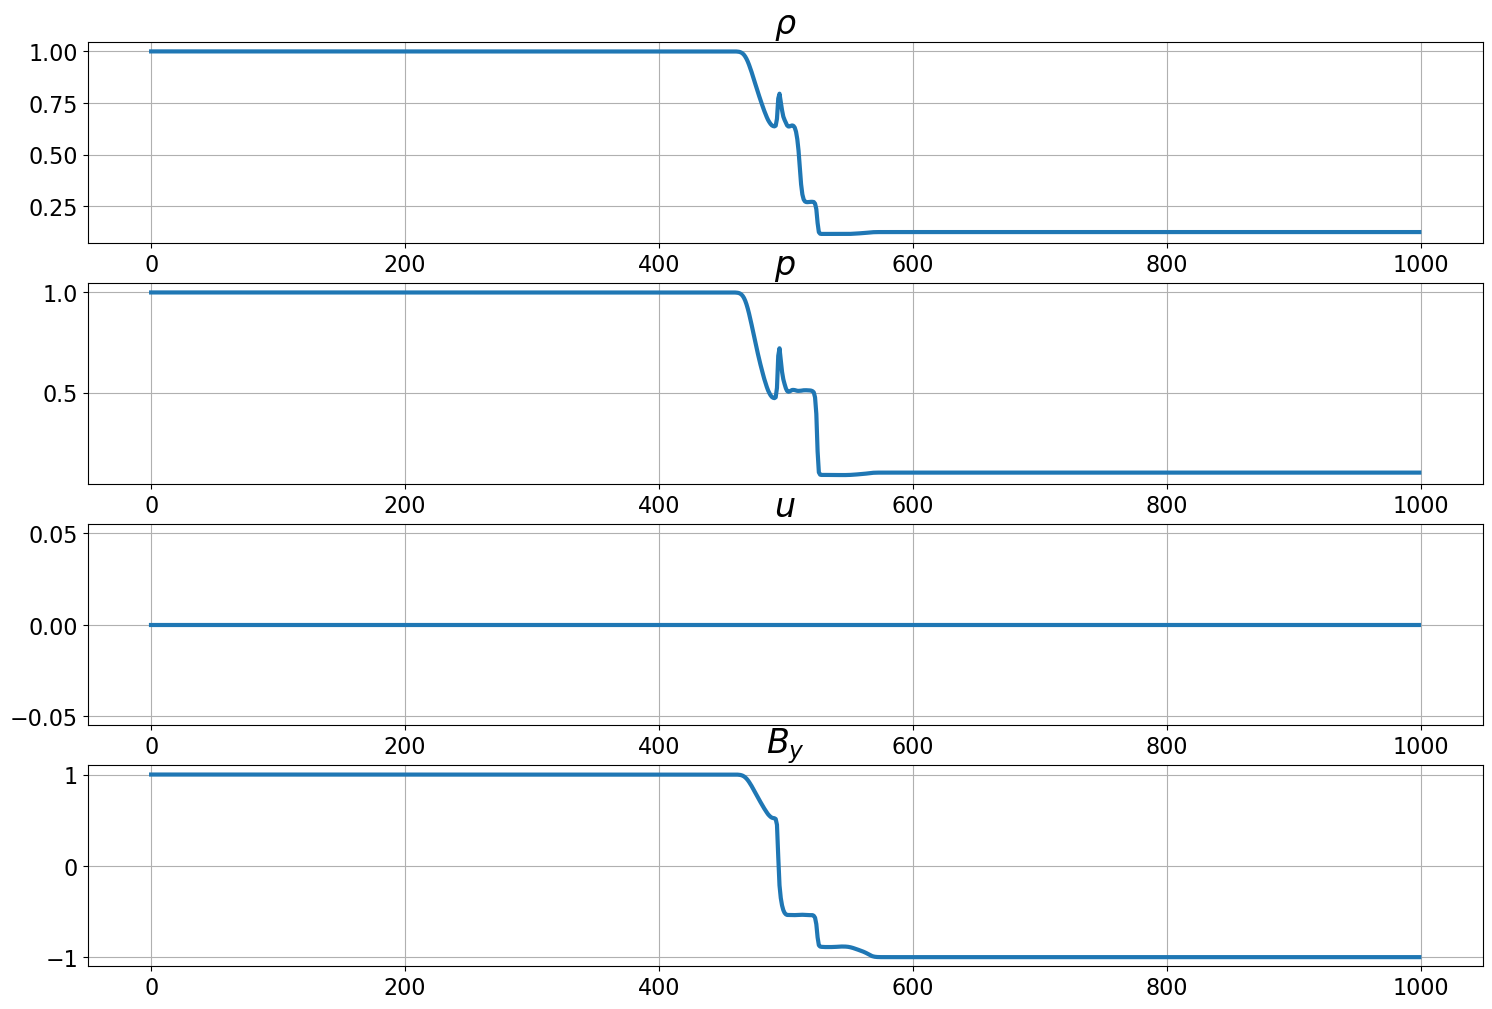

In [5]:
step = 100
U = np.load(f"./results_MHD_shock_tube/U_{step}.npy")


fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

rho = U[0, :]
u = U[1, :] / rho 
v = U[2, :] / rho 
w = U[3, :] / rho 
Bx = U[4, :]
By = U[5, :]
Bz = U[6, :]
e = U[7, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

ax1.plot(x, rho, lw=3)
ax2.plot(x, p, lw=3)
ax3.plot(x, w, lw=3)
ax4.plot(x, By, lw=3)

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$u$", fontsize=24)
ax4.set_title(r"$B_y$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

plt.show()

動画作成

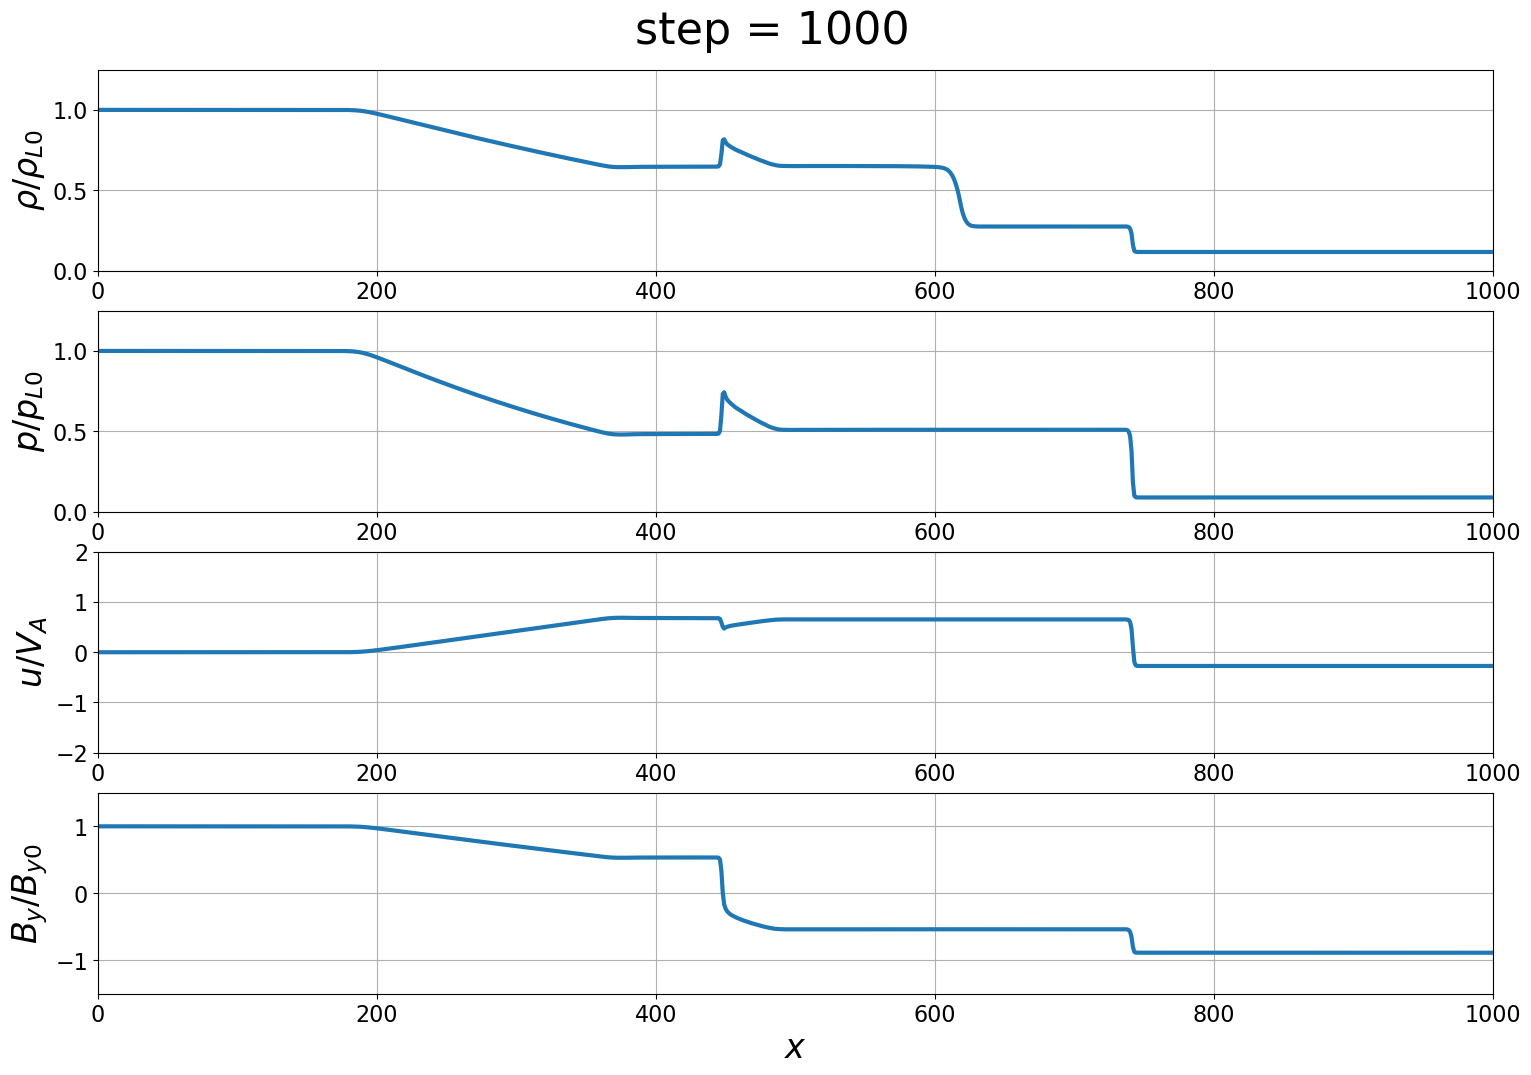

In [4]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

dirname = "results_MHD_shock_tube"
filename = "shock_tube_MHD.mp4"
#log = np.loadtxt('log.txt', dtype=str)

interval = 10
plot_steps = 1000
for step in range(0, plot_steps+1, interval):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()

    U = np.load(f"./{dirname}/U_{step}.npy")

    rho = U[0, :]
    u = U[1, :] / rho 
    v = U[2, :] / rho 
    w = U[3, :] / rho 
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    ax1.plot(x, rho / rho_L_init, lw=3)
    ax2.plot(x, p / p_L_init, lw=3)
    ax3.plot(x, u / VA, lw=3)
    ax4.plot(x, By / B_L_init[1], lw=3)

    ax4.set_xlabel(r"$x$", fontsize=24)
    ax1.set_ylabel(r"$\rho / \rho_{L0}$", fontsize=24)
    ax2.set_ylabel(r"$p / p_{L0}$", fontsize=24)
    ax3.set_ylabel(r"$u / V_A$", fontsize=24)
    ax4.set_ylabel(r"$B_y / B_{y0}$", fontsize=24)
    ax1.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    ax3.tick_params(labelsize=16)
    ax4.tick_params(labelsize=16)
    ax1.set_xlim(0, 1000)
    ax2.set_xlim(0, 1000)
    ax3.set_xlim(0, 1000)
    ax4.set_xlim(0, 1000)
    ax1.set_ylim(0.0, 1.25)
    ax2.set_ylim(0.0, 1.25)
    ax3.set_ylim(-2.0, 2.0)
    ax4.set_ylim(-1.5, 1.5)
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax4.grid()

    plt.suptitle(f"step = {step}", y=0.93, fontsize=32)

    fig.savefig(f'./pictures/{step}.png', dpi=200)


img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 5.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for step in range(0, plot_steps+1, interval):
    img = cv2.imread(f'./pictures/{step}.png')
    video.write(img)
video.release()